# Prediction - European Calls

In [1]:
%run ../nn_option_pricer/_key_imports.py
import sys

sys.path.append("../")
from nn_option_pricer.bergomi import bergomi_eval_wrapper, bergomi_model_inference
from nn_option_pricer.nn_archi import *
from nn_option_pricer.utils import diagnosis_hedge, visualise_surface
%run ../nn_option_pricer/default_config.py

In [2]:
feat_names = ["log-strike", "ttm", "alpha", "rho", "vol-of-vol"]
N_FEATS = len(feat_names)
f_to_i = lambda x: feat_names.index(x)

X_df = pd.read_csv("datasets/rough_bergomi_train.csv")
Xs_train = X_df[feat_names].values
ys_train = X_df["MC_call"]
X_df[f"MC_call_d2_{'log-strike'}"]  = -X_df['MC_digital_delta']
true_grads_train = X_df["MC_call_d_log-strike"]

X_df_test = pd.read_csv("datasets/rough_bergomi_test.csv")
Xs_test = X_df_test[feat_names].values
ys_test = X_df_test["MC_call"]
X_df_test[f"MC_call_d2_{'log-strike'}"]  = -X_df_test['MC_digital_delta']

print("BASELINE MSE: ", np.mean((ys_test - ys_test.mean()) ** 2))
print("BASELINE MAE: ", np.mean(np.abs(ys_test - ys_test.mean())))
print(X_df.shape)

all_res = []
moneyness = np.exp(Xs_test[:, f_to_i("log-strike")])
ttm = np.exp(Xs_test[:, f_to_i("ttm")])
true = X_df_test["MC_call"].values
intrinsic_val = np.maximum(1.0 - moneyness, 0)
upper_bound = 1.0


all_model_preds = {}
all_model_grads = {}
all_model_hessian = {}
all_models = {}

# Example Call Surface
N_POINTS = 128
SK = np.linspace(-3.0, 3, N_POINTS)
ts = np.linspace(0, 2.0, N_POINTS)
X = np.zeros((N_POINTS**2, N_FEATS))
X[:, :2] = np.array(list(product(SK, ts)))
sample_params = X_df.sample(1).iloc[0].to_dict()
for x in [i for i in feat_names if i not in ["ttm", "log-strike"]]:
    X[:, f_to_i(x)] = sample_params[x] * np.ones(X.shape[0])

BASELINE MSE:  0.018323392893329387
BASELINE MAE:  0.119747738753661
(93000, 12)


In [3]:
nn_params["n_feats"] = N_FEATS
fit_params["batch_size"] = 256
LR = 1e-4
nn_params['hidden_units'] = 252

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5)]               0         
                                                                 
 batch_normalization (BatchN  (None, 5)                20        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 252)               1512      
                                                                 
 batch_normalization_1 (Batc  (None, 252)              1008      
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 252)               63756     
                                                                 
 batch_normalization_2 (Batc  (None, 252)              1008  

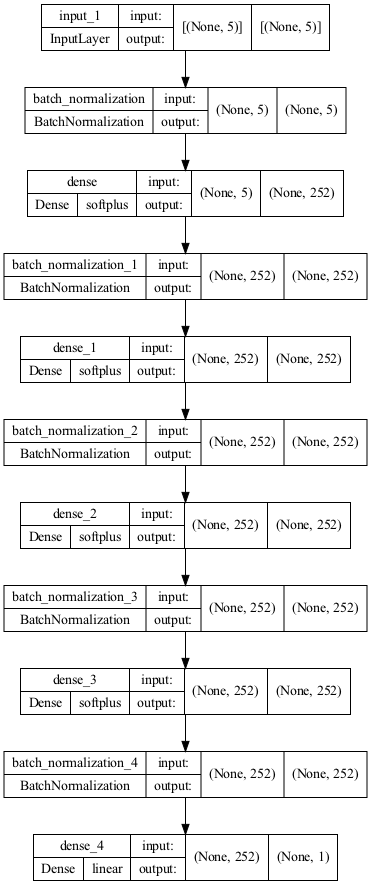

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

2022-07-01 11:35:21.483826: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: trained_models/bergomi/ffn/assets


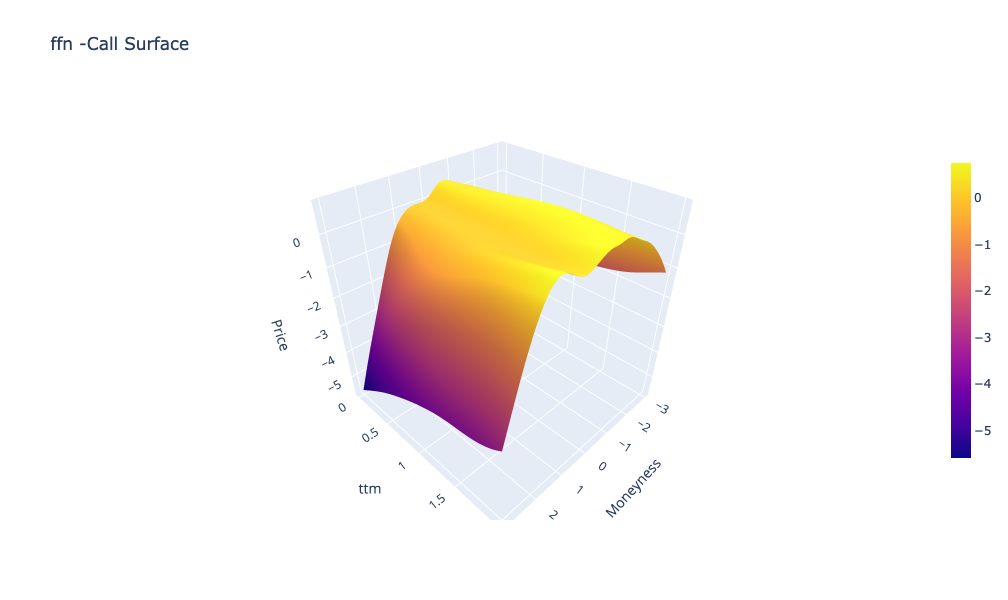

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 5)           20          ['input_2[0][0]']                
 rmalization)                                                                                     
                                                                                                  
 dense_5 (Dense)                (None, 252)          1512        ['batch_normalization_5[0][0]']  
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 252)         1008        ['dense_5[0][0]']          

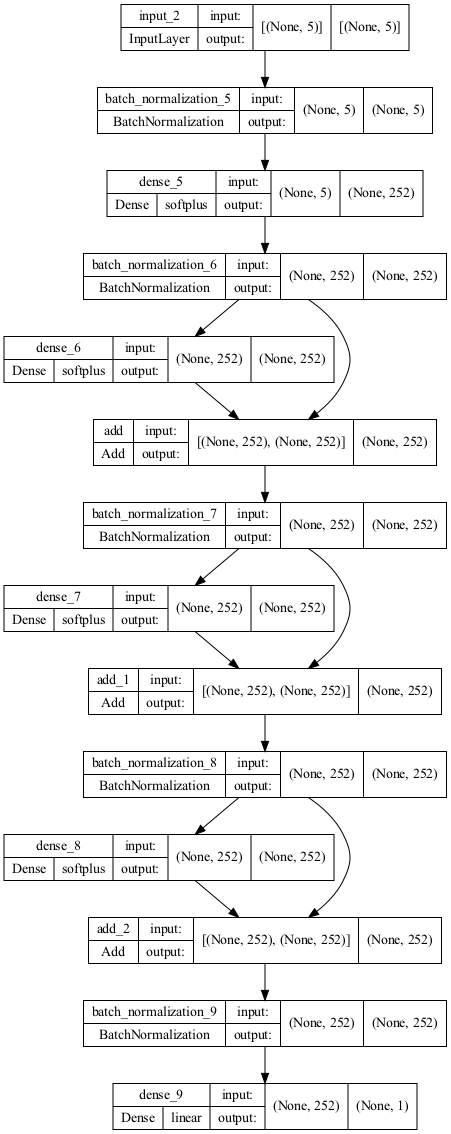

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

INFO:tensorflow:Assets written to: trained_models/bergomi/resnet/assets


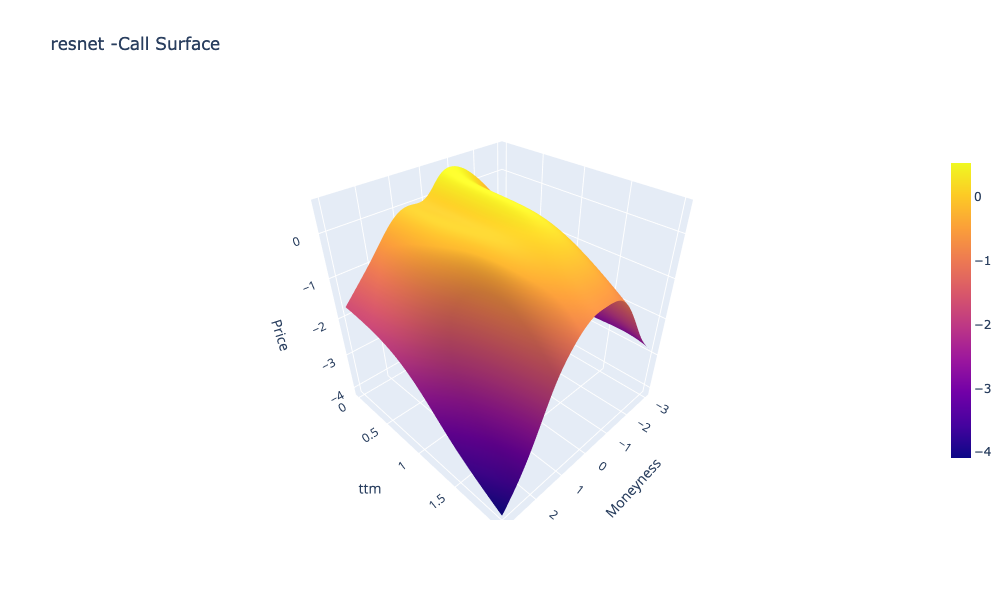

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 batch_normalization_10 (BatchN  (None, 5)           20          ['input_3[0][0]']                
 ormalization)                                                                                    
                                                                                                  
 ttm (Dense)                    (None, 1)            6           ['batch_normalization_10[0][0]'] 
                                                                                                  
 moneyness (Dense)              (None, 1)            6           ['batch_normalization_10[0]

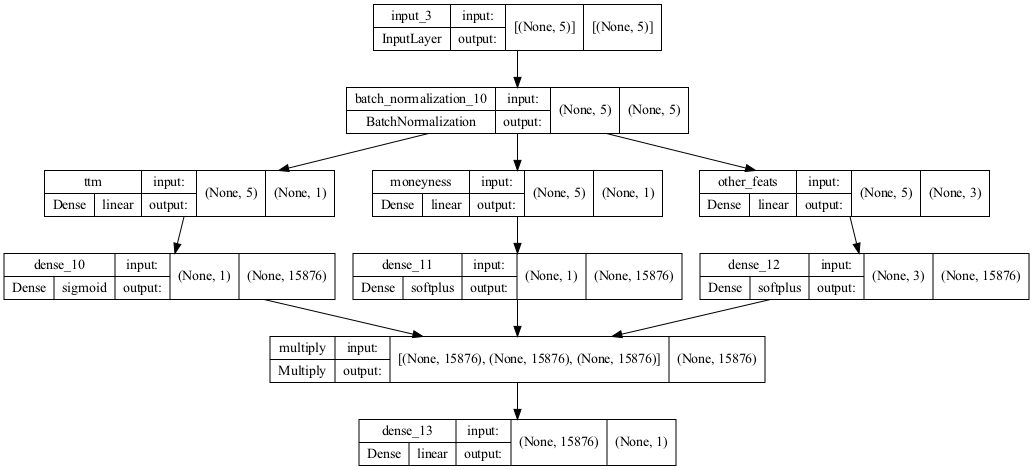

Training:   0%|                                         0/30 ETA: ?s,  ?epochs/s

INFO:tensorflow:Assets written to: trained_models/bergomi/gated/assets


In [ ]:
### define the neural network architecture
for METHOD in ["ffn", "resnet", "gated", "differential"]:
    metrics_to_add = []
    if METHOD == "differential":
        diff_model = make_model(**nn_params)
        all_models[METHOD] = DifferentialModel(diff_model.input, diff_model.output)
        all_models[METHOD].set_params(grad_loss_fn=delta_loss, lam = 1.0)
        metrics_to_add  = ['loss','grad_loss']
    elif METHOD == "gated":
        nn_params2 = nn_params.copy()
        nn_params2['hidden_units'] = (nn_params2['hidden_units'] ** 2) / 4
        for param in ['n_layers', 'hidden_act', 'output_act', 'dropout_ratio']:
            nn_params2.pop(param)
        all_models[METHOD] = homogeneity_network(**nn_params2)
        gated_network_instantiate(all_models[METHOD], f_to_i, feat_map ={"ttm":"ttm", "moneyness":"log-strike"})
    elif METHOD == "resnet":
        nn_params2 = nn_params.copy()
        nn_params2['resnet'] = True
        all_models[METHOD] = make_model(**nn_params2)
    else:
        all_models[METHOD] = make_model(**nn_params)
    opt = Adam(learning_rate=ExponentialDecay(LR, decay_steps=500,
        decay_rate=0.95,
    ))
    ### re-instantiate the optimizer, and compile the neural network
    all_models[METHOD].compile(optimizer=opt, **compile_params)
    ### summarize model
    all_models[METHOD].summary()
    display(tf.keras.utils.plot_model(
        all_models[METHOD], show_layer_activations=True, show_shapes=True, dpi=72
    ))
    #### Training
    try:
        #### try loading the model from disk
        all_models[METHOD] = tf.keras.models.load_model(f"trained_models/bergomi/{METHOD}")
    except:
        ### if not found, retrain
        if METHOD == "differential":
            train_time, history = train_nn(model = all_models[METHOD], 
                               Xs = Xs_train, 
                               ys = (ys_train, true_grads_train), 
                               fit_params = fit_params, 
                               metric_names = metric_names + metrics_to_add, METHOD = METHOD)
        else:
            train_time, history = train_nn(model = all_models[METHOD], 
                               Xs = Xs_train, 
                               ys = ys_train, 
                               fit_params = fit_params, 
                               metric_names = metric_names + metrics_to_add, METHOD = METHOD)
        all_models[METHOD].save(f"trained_models/bergomi/{METHOD}", save_format='tf')   
  
    #### Inference
    temp = bergomi_model_inference(all_models  = all_models, 
                                   all_model_preds = all_model_preds, 
                                   METHOD = METHOD, 
                                   all_model_grads = all_model_grads, 
                                   all_model_hessian = all_model_hessian,
                                   X_df_test = X_df_test, 
                                   Xs_test = Xs_test, 
                                   true = true, 
                                   feat_names = feat_names, 
                                   f_to_i = f_to_i, 
                                   intrinsic_val = intrinsic_val, 
                                   upper_bound = upper_bound)
    try:
        temp["train_time"] = train_time
    except:
        pass
    all_res += [temp.copy()]

# Neural Network Ensemble

In [ ]:
ensemble_preds = pd.DataFrame(all_model_preds).mean(axis=1).values
ensemble_hessian = pd.DataFrame({x:all_model_hessian[x][:, f_to_i("log-strike")] for x in all_model_hessian}).mean(axis = 1).values.reshape((-1, 1))
ensemble_grads = np.zeros((X_df_test.shape[0], N_FEATS))
for i in range(N_FEATS):
    ensemble_grads[:, i] =pd.DataFrame({x:all_model_grads[x][:,0] for x in all_model_grads}).mean(axis = 1).values
METHOD = "nn_ensemble"
temp = bergomi_eval_wrapper(
    X_df_test,
    true,
    ensemble_preds,
    ensemble_grads,
    ensemble_hessian,
    feat_names,
    lower_bound=intrinsic_val,
    upper_bound=upper_bound,
    METHOD=METHOD,
)

all_res += [temp.copy()]

# Polynomial Basis

In [ ]:
from nn_option_pricer.poly_reg import train_infer_poly
import math

METHOD = "poly_reg"
start = time.time()
degree = 5
# spline = SplineTransformer(n_knots=5, degree=10, knots="uniform", extrapolation="linear")
train_time, inference_time = train_infer_poly(degree, X_df, X_df_test, 
                                              feat_names, 'MC_call', 
                                              all_models, all_model_preds, 
                                              all_model_grads, all_model_hessian, 
                                              moneyness_var = "log-strike", 
                                              METHOD=METHOD, eps=0.0001)
temp = bergomi_eval_wrapper(
    X_df_test,
    true,
    all_model_preds[METHOD],
    all_model_grads[METHOD],
    all_model_hessian[METHOD],
    feat_names,
    lower_bound=intrinsic_val,
    upper_bound=upper_bound,
    METHOD=METHOD,
)

temp['train_time'] = train_time
temp["model_parameters"] = len(all_models[METHOD]['lr'].coef_)
temp['inference_time'] = inference_time
all_res += [temp.copy()]

# Results

In [ ]:
res_df = (
    pd.concat(all_res)
    .reset_index()
    .drop_duplicates(subset=["index"], keep="last")
    .set_index("index")
    .T
)
print(res_df.to_latex(float_format = "%.5g", bold_rows=True))
display(res_df.style.background_gradient(axis=1))
res_df.to_csv("results/BergomiResults.csv", index=False)

In [ ]:
sns.scatterplot(X_df_test['log-strike'], 
                X_df_test["MC_call_d_log-strike"] - all_model_grads["differential"][:, f_to_i("log-strike")], 
                hue = X_df_test['ttm'])